In [94]:
import numpy as np

assert np.__version__ == "1.22.4"

In [1]:
import os

# Set path to LIDC dataset for pylidc package (on windows probably doesn't work)
pylidcrc_path = os.path.expanduser("~/.pylidcrc")
pwd = os.getcwd()
path = os.path.join(pwd, "lidc", "LIDC-IDRI")
with open(pylidcrc_path, "w") as f:
    f.write("[dicom]\n")
    f.write(f"path = {path}\n")
    f.write("warn = True\n")

Loading dicom files ... This may take a moment.
(512, 512, 133)


2542

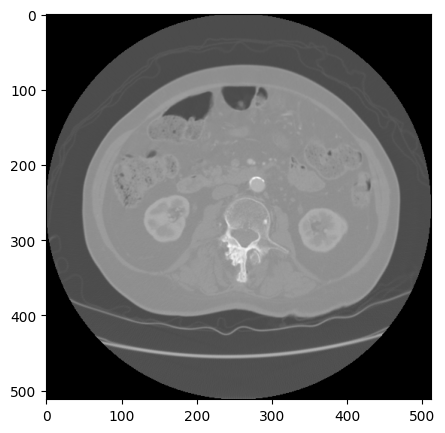

In [3]:
import pylidc as pl
import matplotlib.pyplot as plt


# Showing the first slice of the volume for the first patient
pid = "LIDC-IDRI-0001"
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

vol = scan.to_volume()
print(vol.shape)  # (dim, dim, depth)

nslice = 0
plt.figure(figsize=(5, 5))
plt.set_cmap("gray")
plt.imshow(vol[:, :, nslice])  # Show the first slice

pl.query(pl.Annotation).filter(pl.Annotation.subtlety >= 5).count()

Loading dicom files ... This may take a moment.
Number of nodules: 1
Number of doctor annotations for a nodule: 4


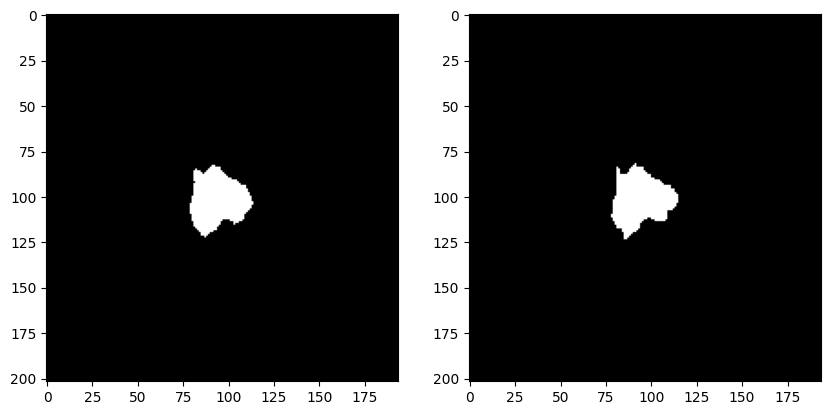

In [206]:
from pylidc.utils import consensus
from skimage.measure import find_contours


pid = "LIDC-IDRI-0001"
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
vol = scan.to_volume()

# Cluster annotations per nodule in a CT scan.
nods = scan.cluster_annotations()
print(f"Number of nodules: {len(nods)}")

anns = nods[0]
print(f"Number of doctor annotations for a nodule: {len(anns)}")

# consensus consolidation and 50% agreement level
clevel = 0.5
consensus_mask, cbbox, masks = consensus(
    anns, clevel=clevel, pad=[(75, 75), (75, 75), (0, 0)]
)

# central slice of the computed bounding box
k = int((cbbox[2].stop - cbbox[2].start) / 2)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
# calculated consensus mask among all doctor annotations for the 4th slice
plt.imshow(consensus_mask[:, :, 4])

plt.subplot(1, 2, 2)
# calculated mask for the 4th slice for the first doctor
plt.imshow(masks[0][:, :, 4])
plt.show()

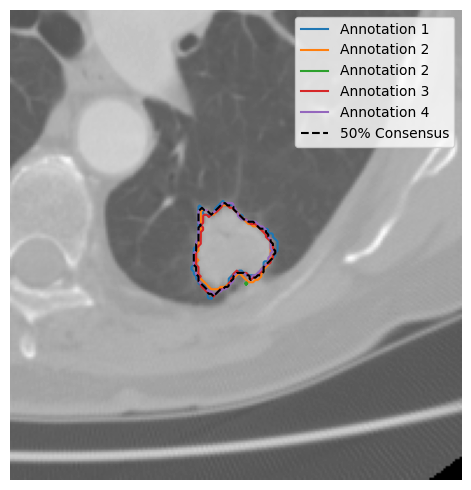

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(vol[cbbox][:, :, k])

# Plot the annotation contours for the kth slice.
for j, mask in enumerate(masks):
    for c in find_contours(mask[:, :, k].astype(float), clevel):
        plt.plot(c[:, 1], c[:, 0], label=f"Annotation {j+1}")

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(consensus_mask[:, :, k].astype(float), clevel):
    plt.plot(c[:, 1], c[:, 0], "--k", label=f"{int(clevel*100)}% Consensus")

ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

Loading dicom files ... This may take a moment.


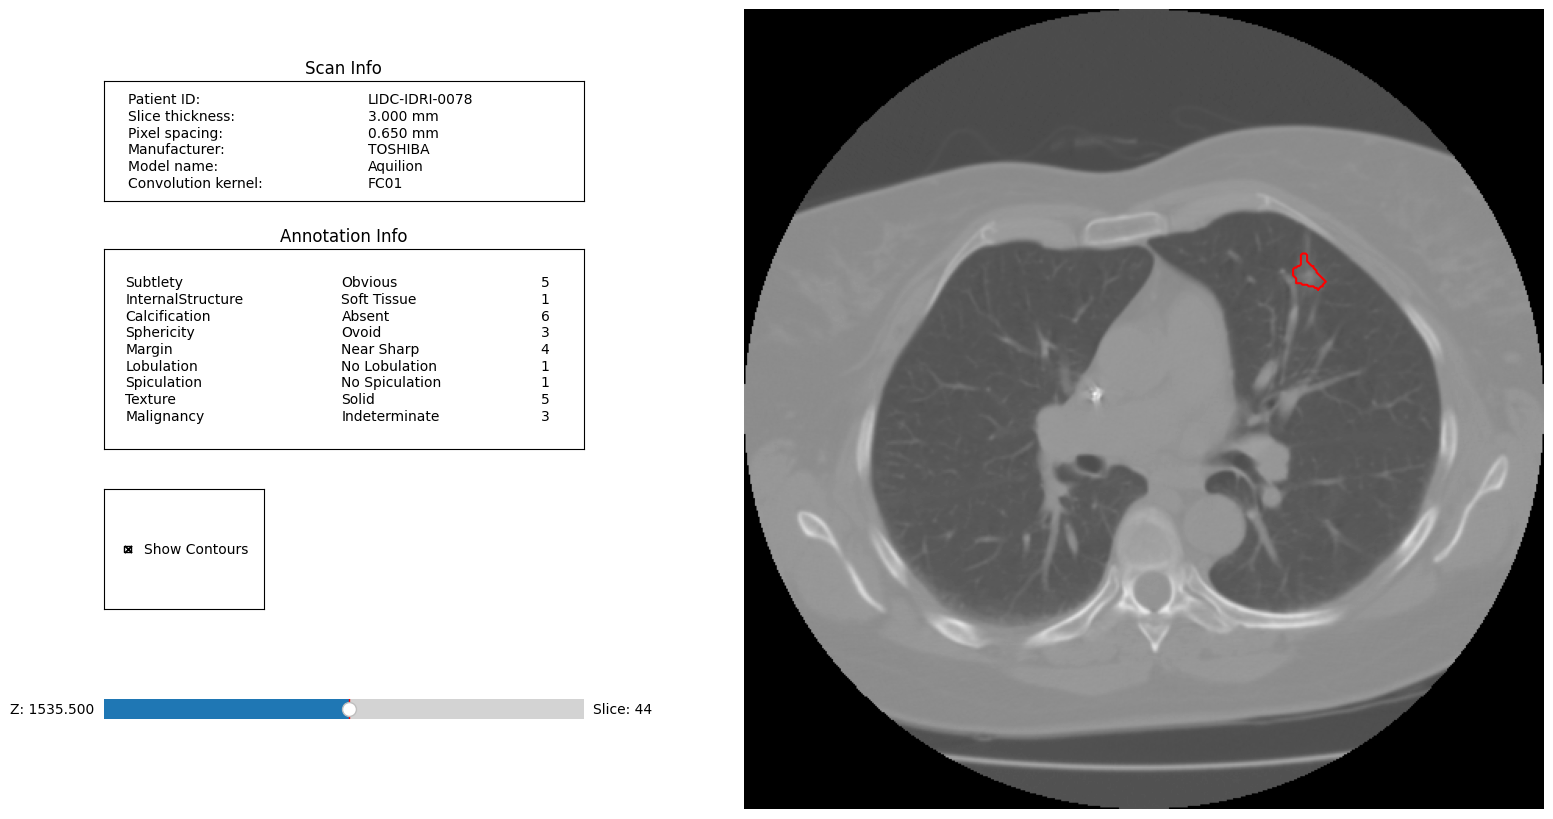

Patient ID: LIDC-IDRI-0078
Number of all annotations for every doctor in every slice: 13
Loading dicom files ... This may take a moment.


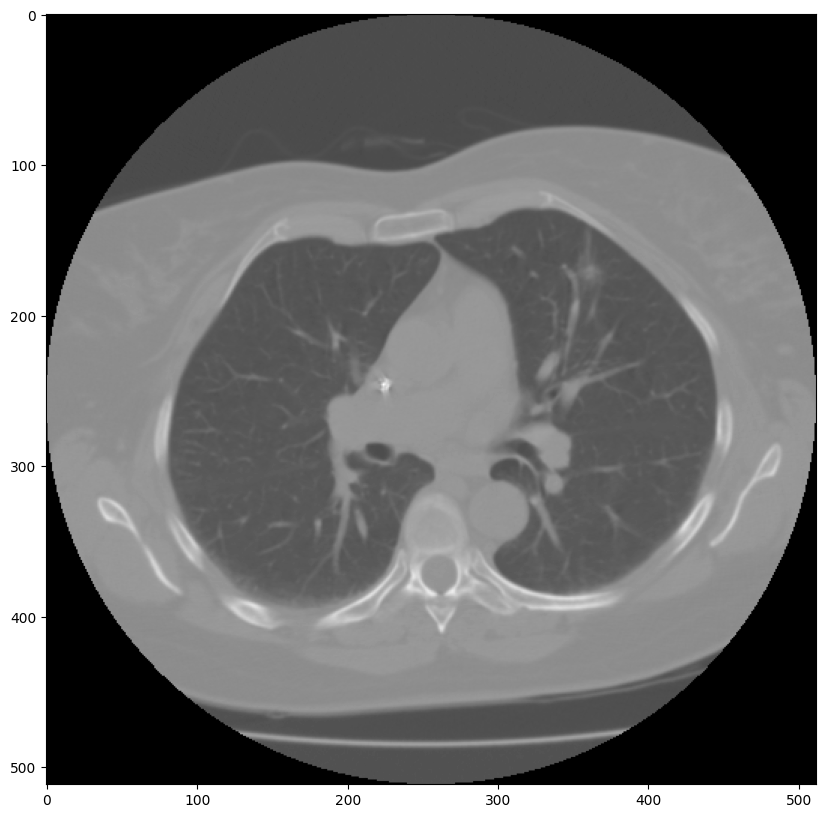

In [188]:
# Get first annotation with subtlety of 5 and visualize it in the scan
anno = pl.query(pl.Annotation).filter(pl.Annotation.subtlety == 5).first()
anno.visualize_in_scan()

pid = anno.scan.patient_id
print(f"Patient ID: {pid}")

print(
    f"Number of all annotations for every doctor in every slice: {len(anno.scan.annotations)}"
)
vol = anno.scan.to_volume()

contour_slice_indices = anno.contour_slice_indices
plt.figure(figsize=(10, 10))
plt.imshow(vol[:, :, contour_slice_indices[0]])
plt.show()

Loading dicom files ... This may take a moment.


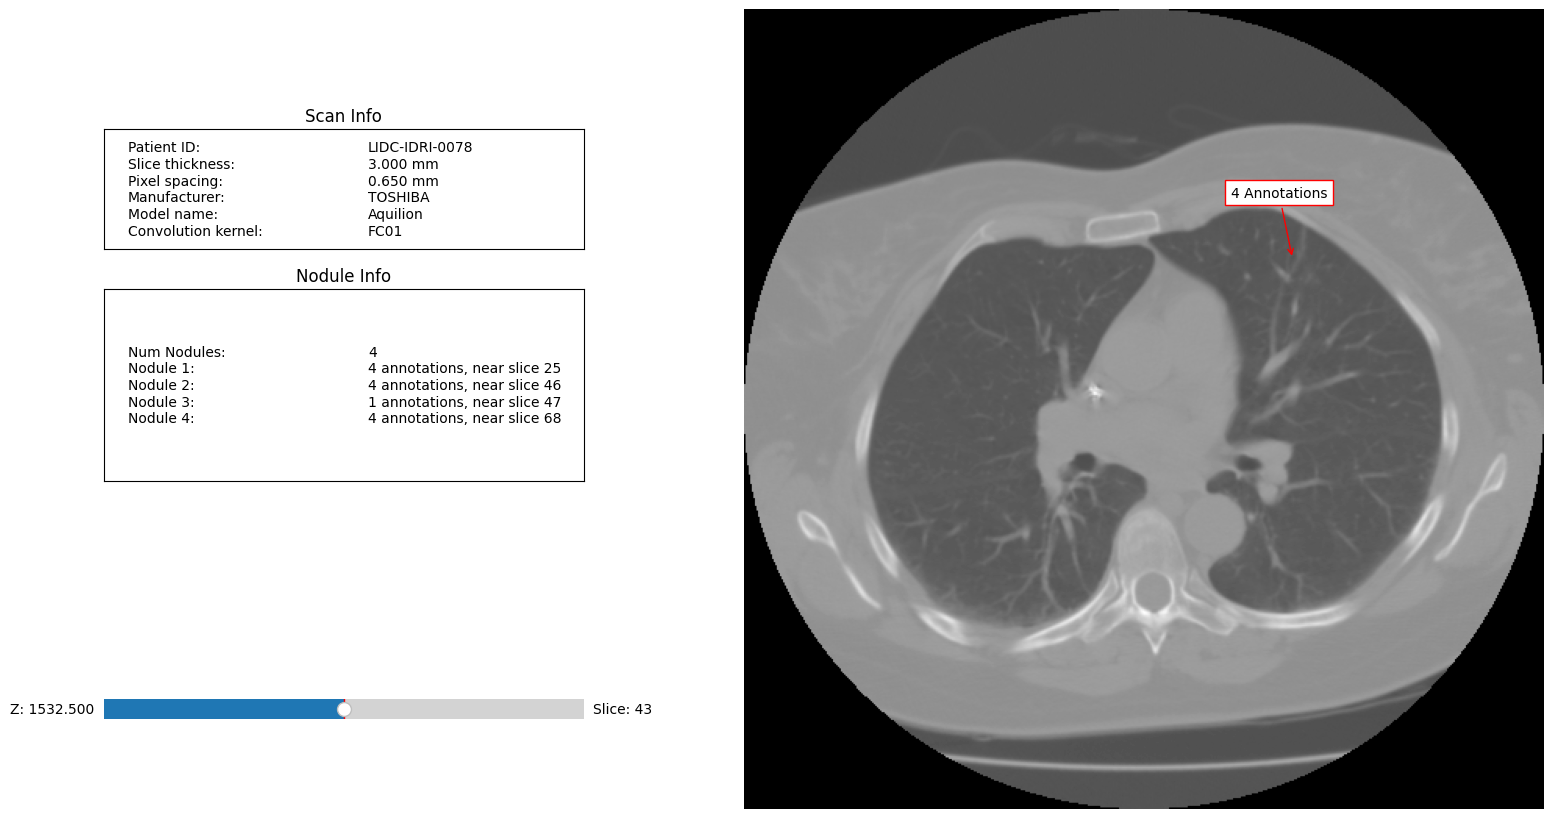

In [194]:
pid = "LIDC-IDRI-0078"
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

scan.visualize(annotation_groups=scan.cluster_annotations())

Loading dicom files ... This may take a moment.
(54, 47, 6)
(54, 47, 6)


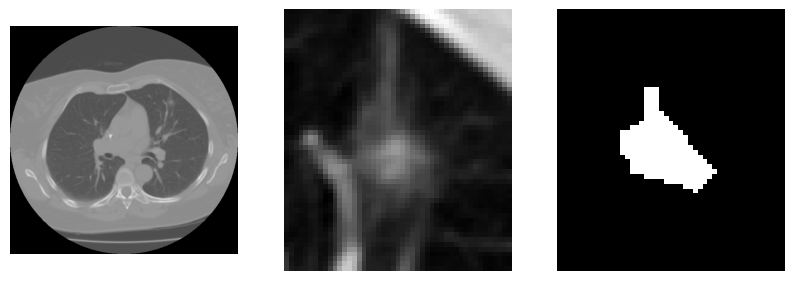

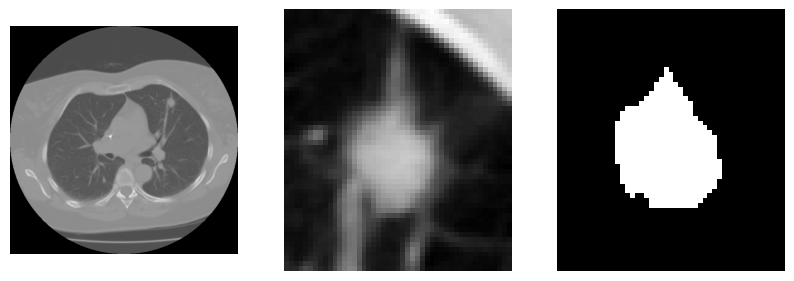

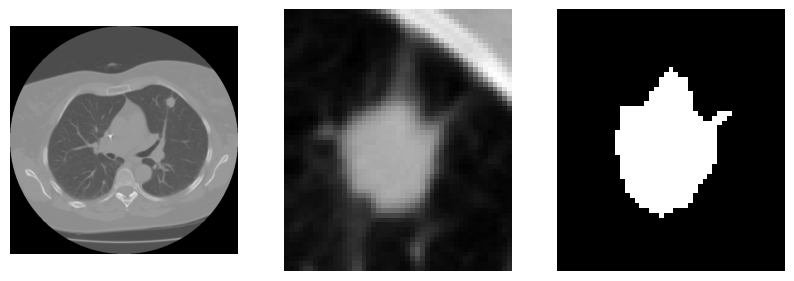

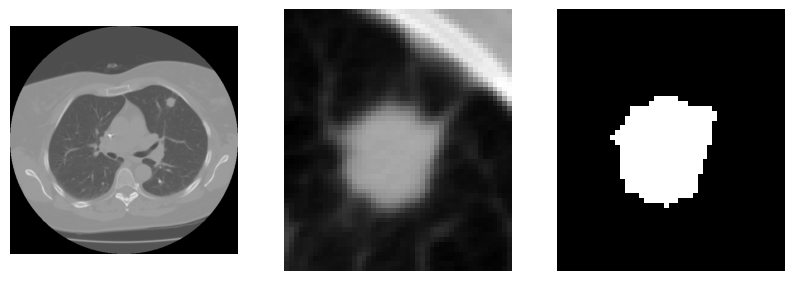

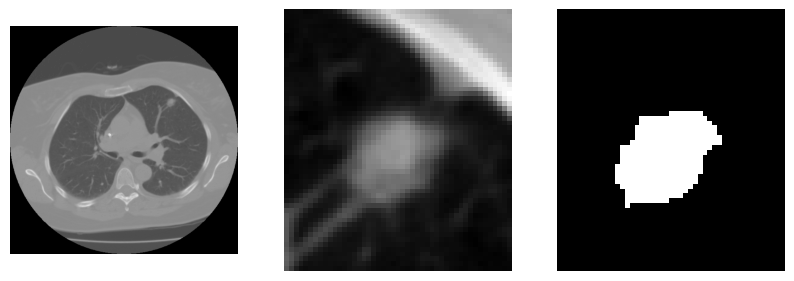

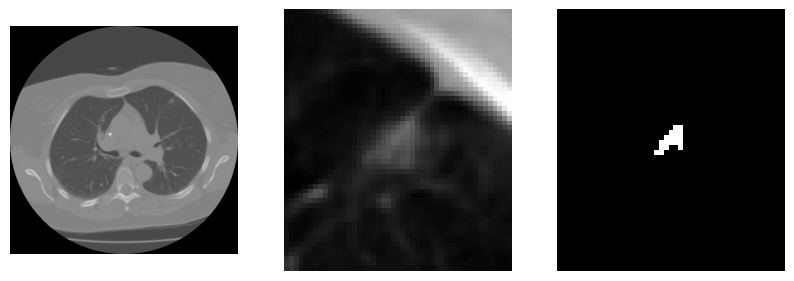

In [242]:
padding = [(10, 10), (10, 10), (0, 0)]
anno = pl.query(pl.Annotation).filter(pl.Annotation.subtlety == 5).first()
vol = anno.scan.to_volume()

masks = anno.boolean_mask(pad=padding)
bbox = anno.bbox(pad=padding)
relevant_vol = vol[bbox]

print(masks.shape)
print(relevant_vol.shape)

for region in range(masks.shape[2]):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(vol[:, :, anno.contour_slice_indices[region]])
    plt.subplot(1, 3, 2)
    plt.imshow(relevant_vol[:, :, region])
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(masks[:, :, region])
    plt.axis("off")
    plt.show()
    plt.close()